![datiaperti logo](images/datiaperti_small.png)

# Corner detection
A corner is a point of interest in an image in which the gradient takes strong values in all directions. It is used to locate and track objects in an image. One of the first operators to find out corner points has been developed by Harris and Stephens and is based on the gradient operator. The Harris operator is isotropic, that is, the operator's value in one pixel does not depend on the orientation of the gradient.

In [9]:
import numpy as np
import math
import skimage
from skimage import io
from skimage import filters
from skimage import util
import matplotlib as mpl
import matplotlib.pyplot as plt
from platform import python_version
print("python version: %s"%python_version())
print("numpy version: %s"%np.__version__)
#print("pandas version: %s"%pd.__version__)
print("skimage version: %s"%skimage.__version__)
print("matplotlib version: %s"%mpl.__version__)

python version: 3.11.5
numpy version: 1.25.2
skimage version: 0.22.0
matplotlib version: 3.8.0


## The Harris corner detector
A good description of the Harris corner detector is available on [Wikipedia](https://en.wikipedia.org/wiki/Harris_Corner_Detector). In few words the Harris detector computes the first derivatives of the image's intensity I(u, v) and their autocorrelation, also called the structure tensor M, at each point (u, v) of the image 

$$ I_x(u, v) = \frac{\partial I(u, v)}{\partial x}, I_y(u, v) = \frac{\partial I(u, v)}{\partial y} $$

$$ M(u, v) = \begin{bmatrix} <I_x(u, v)>^2 & <I_x(u, v)><I_y(u, v)> \\ <I_y(u, v)><I_x(u, v)> & <I_y(u, v)>^2 \end{bmatrix} $$

The next step is to find one direction with the strongest autocorrelation whose ortogonal direction is also strong. In algebric terms this means finding two eigenvectors of M, whose eigenvalues are strong and not too different. The eigenvalues can be found by determining the solution of the equation

$$ det(M(u, v) - \lambda I) = 0 $$

Here I represents the identity matrix and should not be confused with the intensity function. The solution of the equation is

$$ \lambda_{1, 2} = \frac{tr(M)}{2} \pm \frac{\sqrt{tr(M)^2 - 4 det(M)}}{2}$$

and the difference between the two eigenvalues is

$$ \lambda_1 - \lambda_2 = 2  \sqrt{\frac{1}{4}tr(M)^2 - det(M)}$$

where tr(M) is the trace of the structure tensor M and det(M) is the determinant. In the [Harris' original paper](http://www.bmva.org/bmvc/1988/avc-88-023.pdf) the corner points are selected by computing the response R that is defined as the squared difference of the eigenvalues but using a parameter $\alpha$ instead of the constant $\frac{1}{4}$. 

$$ R = det(M) - \alpha Tr(M)^2$$

The parameter $\alpha$ is used to set the sensitivity of the detector, the larger its value, the less sensitive is the detector. In general $\alpha$ is assigned a value between 0.04 and 0.06. We use other two parameters in our function implementation of the Harris' detector. One parameter is the threshold, the minimum value of the response that we accept for a point to be a corner. The threshold is usually set between $10^4$ and $10^6$. At this point we would collect many potential corners, or candidates, that are adjacent or very close to the real corner point so we have to suppress such points before returning the list of corners. We can suppress the candidate points close to the corner by setting a minimum distance in which if we find a neighbor candidate whose corner response is higher than that of the candidate we are visiting, then it is removed from the candidates. We implement the Harris' corner detector and a Gaussian Filter that is used to smooth the elements of the structure tesor M before computing the corner response. 

In [10]:
def dip_gaussianFilter(image):
    # Creates a smoothed image from the input one by computing the
    # average value of each pixel from its neighbors' values. The size
    # of the filter is 5x5
    H = np.array(((0, 1, 2, 1, 0), 
                  (1, 3, 5, 3, 1), 
                  (2, 5, 9, 5, 2), 
                  (1, 3, 5, 3, 1), 
                  (0, 1, 2, 1, 0))) # filter
    rows = image.shape[0]
    cols = image.shape[1]
    smooth_img = np.zeros((rows, cols), dtype=int)
    
    for col in range(0, cols - 1):
        for row in range(0, rows - 1):
            sum = 0
            for i in range(-1, 2):
                for j in range(-1, 2):
                    v = image[row + i, col + j] * H[i + 1, j + 1]
                    sum = sum + v
            smooth_img[row, col] = int(round( sum ))
    
    return smooth_img / 57

We import the definitions of the horizontal and vertical derivatives that we have developed for edge detection.

In [11]:
%run dip_functions.ipynb

In [12]:
#from ipynb.fs.full.dip_functions import dip_horizontalDerivative
#from ipynb.fs.full.dip_functions import dip_verticalDerivative

In [13]:
def corner_response(image, alpha, threshold, dist):
    rows = image.shape[0]
    cols = image.shape[1]
    candidates = np.zeros((rows, cols), dtype=int)  # at most each pixel is a point of interest
    Ix = dip_horizontalDerivative(image)
    Iy = dip_verticalDerivative(image)
    A = Ix * Ix
    B = Iy * Iy
    C = Ix * Iy
    A_ = dip_gaussianFilter(A)
    B_ = dip_gaussianFilter(B)
    C_ = dip_gaussianFilter(C)
    R = A_ * B_  - C_ * C_ - alpha * (A_ + B_) * (A_ + B_) # corner response
    
    # Finds candidate corners
    num_candidates = 0
    for col in range(1, cols):
        for row in range(1, rows):
            if R[row, col] > threshold:
                candidates[row, col] = 1
                num_candidates += 1
    
    # Removes the false corner points (points close to the real corner point).
    # If the response R of a candidate corner point is lower than that of an adjacent 
    # candidate point, it is removed from the candidates.
    for col in range(dist, cols - dist):
        for row in range(dist, rows - dist):
            candidate_q = R[row, col]
            is_false_candidate = False
            for i in range(-dist, dist + 1):
                for j in range(-dist, dist + 1):
                    adj_q = R[row + i, col + j]
                    if candidates[row, col] == 1 and adj_q > candidate_q:
                        candidates[row, col] = 0 # removes point from candidates
                        is_false_candidate = True
                        break
            if is_false_candidate:
                    num_candidates -= 1 
    
    # Copies the corners points in an two dimensional array
    corners = np.zeros((num_candidates, 2), dtype=int)
    counter = 0
    for col in range(0, cols):
        for row in range(0, rows):
            if candidates[row, col] == 1:
                corners[counter, 0] = row
                corners[counter, 1] = col
                counter += 1
    
    return corners

### Corner detection in a geometric image
We first apply the Harris' corner detector to a geometric image in which the corners are well defined.

In [14]:
checkboard_img = skimage.data.checkerboard()
corners = corner_response(checkboard_img, 0.06, 2500000, 4) 
corners.shape

(49, 2)

(0.0, 200.0, 200.0, 0.0)

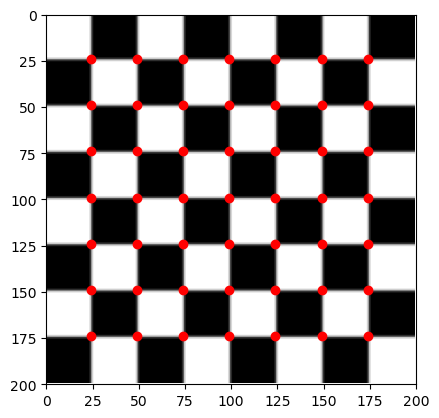

In [15]:
fig, ax = plt.subplots()
ax.imshow(checkboard_img, cmap=plt.cm.gray)
ax.plot(corners[:, 1], corners[:, 0], color='red', marker='o', linestyle='None', markersize=6)
ax.axis((0, 200, 200, 0))

We can see that the algorithm is able to find all the corners but the ones on the border of the chess board since we do not use those points in the algorithm to avoid some complications when we compute the derivatives and the gaussian filter.

### Corner detection in an urban scene
We now apply our implementation of the Harris corner detector to an urban scene with buildings, windows, trees and other structures. 

In [16]:
example_img = io.imread('images/monastero_catania.jpg')[:,:,0]
example_img.shape

(600, 800)

In [17]:
corners_example = corner_response(example_img, 0.04, 100000, 5)
corners_example.shape

(494, 2)

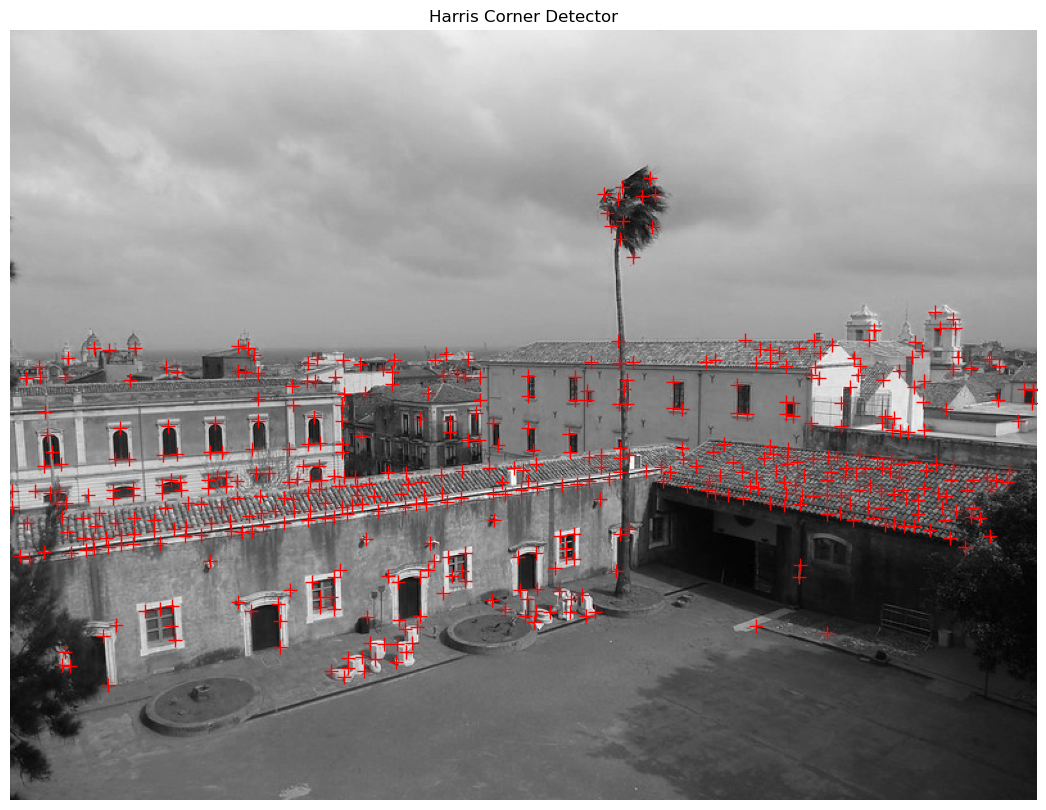

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.imshow(example_img, cmap=plt.cm.gray)
ax.set_title('Harris Corner Detector')
ax.set_axis_off()
ax.plot(corners_example[:, 1], corners_example[:, 0], color='red', marker='+', linestyle='None', markersize=10)

We can see that our implementation of the Harris' corner detector is able to find many corner points, or more generally points of interest, for example buildings', doors' and windows' corners. We can also see that it has some issues. It is fooled by the texture of the rooves, and by the branches of the tree. It finds a corner between the palm tree and the roof of the building behind it. Likely, playing with the minimum distance, we could remove more corners from the rooves. 

## A comparison with the Scikit-image implementation of the Harris' corner detector
We want to compare our implementation with that available from [scikit-image](https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_corner.html?highlight=example%20corner%20detection). The comparison is not about the speed of the algorithm since our implementation has not been optimized. We want just to see what results can be achieved with an implementation that is meant for production.

In [19]:
from skimage.feature import corner_harris, corner_peaks
coords = corner_peaks(corner_harris(example_img), min_distance=5, threshold_rel=0.02)
coords.shape

(436, 2)

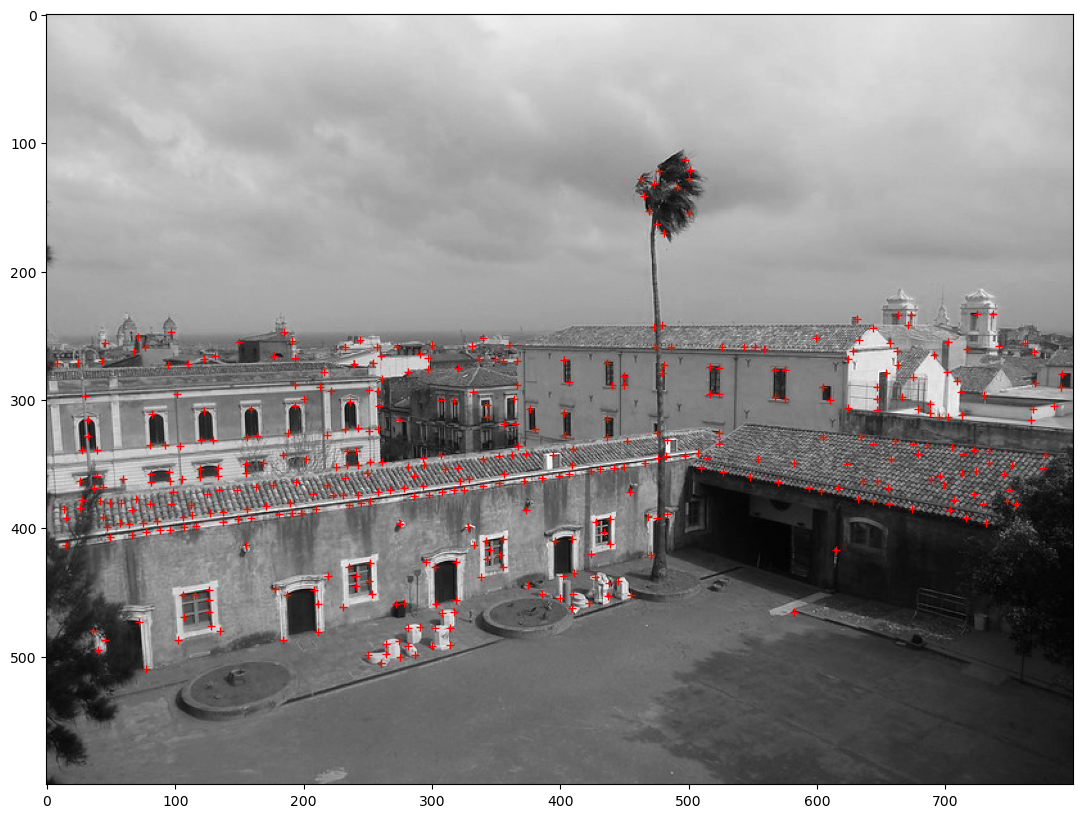

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
ax.imshow(example_img, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='red', marker='+', linestyle='None', markersize=6)
plt.show()

We can see that the scikit-image implementation, beyond being much faster, is able to find mostly the same corner points we have found with our implementation and that it is affected by the same issues we have discussed. Many other algorithms have been developed for the corner detection task but the Harris' corner detector is still the most used.